# Exploratory data analysis
## Data 765 tutoring

[matplotlib](https://matplotlib.org/) is an ancient package at the nexus of plotting in Python. `matplotlib` is vast and powerful but sometimes unwieldly due to its lower level nature. Other plotting libraries, such as [seaborn](https://seaborn.pydata.org/), itself built on `matplotlib`, are a few layers higher than `matplotlib` and thus produce pleasing visualizations quickly. `seaborn` conveniently supports different plot types or features like coloring by a variable that would need to be programmed manually. `matplotlib` implements the drawing primitives necessary for plots and provides full access to those objects.

I personally grew to love `matplotlib` after my thesis for this program as well as 790. Prior to those two courses I disliked `matplotlib` and even `seaborn`, both of which I felt were archaic and difficult. I now prefer `matplotlib` and `seaborn` to R's `ggplot2` after learning how to navigate the library.

Libraries such as `ggplot2` and `seaborn` are excellent for reasonably aesthetic visualizations with a minimum amount of work. However, you will invariable need to drop down a few levels in order to produce more specialized visualizations. `matplotlib` is omnipresent and powerful. `ggplot2`, in my opinion, becomes increasingly convoluted whenever anything moderately complicated is required. The same could be said about R in general. Like `pandas` in relation to `NumPy`, `seaborn` et alia are intricately tied to `matplotlib` such that seamlessly moving between them vastly increases your productivity.

The official site lists [many of the third party](https://matplotlib.org/mpl-third-party/) libraries built on `matplotlib`. I suggest checking it out to get a grasp on the landscape.

## What is exploratory data analysis?
Visualizing your data is an important step to both understanding and presenting your data.

Exploratory data analysis (EDA) with plots is different than analyzing calculations such as summary statistics. Summary statistics are useful to condense your data down to a few numbers. Humans can't grasp the trends of dozens or hundreds of observations. EDA involves plotting your data so that you can observe more than what summary statistics offers. Both are useful, but scatter plots and density plots show all of your observations for particular variables.

Actually observing your data can often provide insights that summary statistics miss. For example, with a scatter plot you can look at how two variables interact which in turn may warrant further study. Scatter plots also help uncover colinearity.

EDA generally consist of quick and dirty plots. You may show EDA in a paper such as in a methods section where you explain how you crafted a topic or your models. In that case you'd spruce up your plots so they're not in tiny rectangles with unlabeled axes. REPL is well suited to EDA because you'll find yourself swapping variables around or crafting different plots.

Unlike the `pandas` mini-lectures, I'd like to go back to augmenting the lectures this week.

Let's first set up a little environment by loading all of the requisite libraries and data.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from pandas.api.types import CategoricalDtype
from matplotlib.patches import Patch

pokemon = pd.read_csv("../data/pokedex.csv")

# Drop unused columns
pokemon.drop(
    columns=[
        "Unnamed: 0",
        "german_name",
        "japanese_name",
        "abilities_number",
        "type_number",
    ],
    inplace=True,
)

# Type conversion
pokemon = pokemon.astype(
    {
        "name": "string",
        "status": "category",
        "species": "string",
        "type_1": "category",
        "type_2": "category",
        "ability_1": "category",
        "ability_2": "category",
    }
)

pokemon.generation = pokemon.generation.astype(CategoricalDtype(ordered=True))

# Tukey's rule functions from last session


def iqr(features):
    """Calculate IQR for a Series or DataFrame

    Parameters
    ----------
    features: Union[pd.Series, pd.DataFrame]
         Series or DataFrame for which to calculate IQR(s).

    Returns
    -------
    Union[float, pd.DataFrame]
         Returns the IQR as a float or IQRs as a DataFrame.
    """
    quantiles = features.quantile([0.25, 0.75])
    return quantiles.loc[0.75] - quantiles.loc[0.25]


def iqr_rule(features):
    """Construct boolean array(s) for outliers via Tukey's rule.

    Parameters
    ----------
    features: Union[pd.Series, pd.DataFrame]
         Series or DataFrame for which to construct boolean arrays.

    Returns
    -------
    Union[pd.Series, pd.DataFrame]
         Boolean arrays for outliers.
    """
    iqr_rule = 1.5 * iqr(features)
    iqr_lower = features.quantile(0.25) - iqr_rule
    iqr_upper = features.quantile(0.75) + iqr_rule

    return ((features < iqr_lower) | (features > iqr_upper)).any(axis="columns")


# `matplotlib`'s object orientated API

`matplotlib` supports two high level APIs—Pyplot and an object orientated interface. Pyplot is easier while the OOP interface is more powerful. Pyplot's functions operate on a single figure where state is built up through successive calls.

The OOP interface is required in order to build more complicated plots or construct multiple plots over time. With that API, you directly manage a [Figure](https://matplotlib.org/stable/api/figure_api.html) instance as well as associated [Axes](https://matplotlib.org/stable/api/axes_api.html) rather than deferring to Pyplot's internal objects. The OOP API also eases working with lower level objects such as [patches](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html).

Let's look at the difference between these two APIs with a simple example.

(But before that I have to define some constants to use later.)

In [37]:
# These colors were copied wholesale from another project I worked on.
# https://github.com/joshuamegnauth54/Data790_PyVis/blob/main/misc/joshua_megnauth_pset2.ipynb

yellow = "#ffcb05"
blue = "#3d7dca"
dark_blue = "#003a70"
nintendo = "#e4000f"
sapphire = "#0f52ba"
ruby = "#e0115f"

# https://bulbapedia.bulbagarden.net/wiki/Category:Color_templates
poketype_colors = {
    "Water": "#6890F0",
    "Fire": "#F08030",
    "Grass": "#78C850",
    "Electric": "#F8D030",
    "Ice": "#98D8D8",
    "Psychic": "#F85888",
    "Dragon": "#7038F8",
    "Dark": "#705848",
    "Fairy": "#EE99AC",
    "Normal": "#A8A878",
    "Fighting": "#C03028",
    "Flying": "#A890F0",
    "Poison": "#A040A0",
    "Ground": "#E0C068",
    "Rock": "#B8A038",
    "Bug": "#A8B820",
    "Ghost": "#705898",
    "Steel": "#B8B8D0",
    "Unknown": "#68A090",
}

# Same link
stat_colors = {
    "Atk.": "#F08030",
    "Defense": "#F8D030",
    "Sp. Atk.": "#6890F0",
    "Sp. Def.": "#78C850",
    "Speed": "#F85888",
    "Hit Points": "#FF0000",
    "Total (Base)": "#D77AFF",
}


First up is the Pyplot API. I won't explain everything in detail since the actual lecture covered the basics.

Text(0.5, 1.0, 'Pokémon special attack versus special defense')

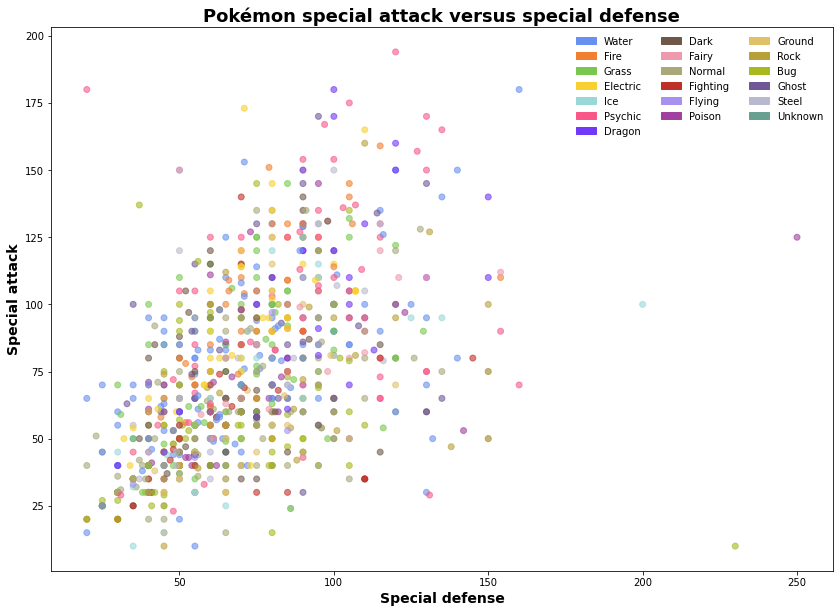

In [38]:
# Map type names to colors
type_colors = pokemon.type_1.map(lambda primary: poketype_colors[primary])
type_patches = {
    type_lab: Patch(color=type_color)
    for type_lab, type_color in poketype_colors.items()
}

# Default font dictionaries
title_default = {"fontweight": "bold", "fontsize": 18}
lab_default = {"fontweight": "bold", "fontsize": 14}

plt.figure(figsize=(14, 10))
plt.scatter(pokemon.sp_defense, pokemon.sp_attack, c=type_colors, alpha=0.6)
plt.legend(type_patches.values(), type_patches.keys(), ncol=3, frameon=False)

plt.xlabel("Special defense", lab_default)
plt.ylabel("Special attack", lab_default)
plt.title("Pokémon special attack versus special defense", title_default)


The plot above is simple but a bit messy due to the colors, but displaying primary type information is always fun!

`type_colors` is a `list` of colors that spans the length of the `DataFrame`. Each primary type (`type_1`) is mapped to a color based on a `dict` defined earlier.

Pyplot uses an internal `Figure` instance. I set that figure's size to `(14, 10)` on line 9 to improve the visibility of the points and so the legend doesn't overlap with any glyphs. Lines 10 to 12 construct the scatter plot with special defense on the x axis and special attack on the y axis. The colors from earlier are applied to each glyph and the alpha channel is set to 0.6 to mitigate the effects of over plotting.

I manually created a legend from `Patch` objects. `matplotlib` automatically generates great legends with a simple function call. However, since I manually colored each glyph, legend creation is a bit wonky because each label has to match the order in the `DataFrame`. I don't really want to deal with that, so creating a `list` of `Patch` objects is easier.

With that said, this is a simple plot that can be constructed with even less work using `seaborn`. Let's look at the OOP interface now.

Text(0.5, 1.0, 'Pokémon special attack versus special defense')

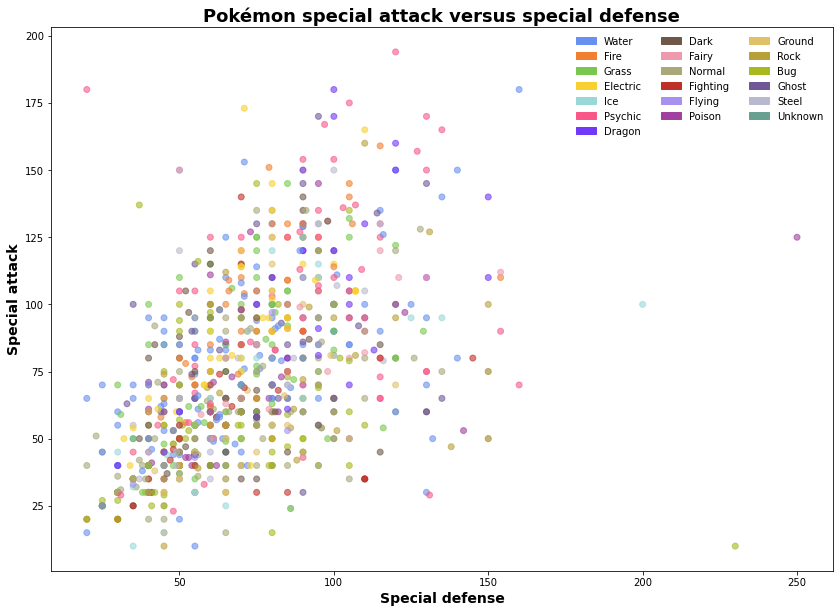

In [39]:
# Create an instance of Figure and Axes
sp_defatk_fig, sp_defatk_ax = plt.subplots(figsize=(14, 10))

# The functions are the same but called on the Axes object
sp_defatk_ax.scatter(pokemon.sp_defense, pokemon.sp_attack, c=type_colors, alpha=0.6)
sp_defatk_ax.legend(type_patches.values(), type_patches.keys(), ncol=3, frameon=False)

# Essentially the same functions as Pyplot but with set_
sp_defatk_ax.set_xlabel("Special defense", lab_default)
sp_defatk_ax.set_ylabel("Special attack", lab_default)
sp_defatk_ax.set_title("Pokémon special attack versus special defense", title_default)


The OOP API doesn't look radically different than from Pyplot. The API uses the same function names as Pyplot except spread across the Axes and Figure object. Why bother with this over Pyplot?

Advanced plots or layering features is easier using the OOP API. Functions could take in Figure and Axes to customize in some way. Another strategy is to write a set of functions for a specialized plot type that returns a Figure and Axes.

# Lollypop plot example
A lollypop plot is a bar plot with sticks replacing the bars with filled circles at the end. Lollypop plots are better for representing a lot of categories. Bar plots look cluttered with too many categories.

In [40]:
def lollypop(col, data=None, figsize=None, ax=None, cat_colors=None, hlines_kwargs=None, plot_kwargs=None):

     # Calculate counts of col (array) or data[col]
     if data:
          data_counts = data[col].value_counts().sort_values(ascending=False)
          cat_labels = data_counts.index.to_numpy()
          counts = data_counts.to_numpy()
     else:
          # N.b. return_counts returns a tuple containing two arrays that must be unpacked
          data_counts = dict(zip(*np.unique(col, return_counts=True)))
          data_counts = sorted(data_counts.items(), key=lambda pair: pair[1])
          # NumPy array for type consistency
          cat_labels = np.array([pair[0] for pair in data_counts])
          counts = np.array([pair[1] for pair in data_counts])

     # Create Axes if needed
     if not ax:
          _fig, ax = plt.subplots(figsize=figsize)
        
     if isinstance(cat_colors, dict):
        cat_colors = [cat_colors[key] for key in cat_labels]

     # Set empty defaults for kwargs
     if not hlines_kwargs:
          hlines_kwargs = {}
     if not plot_kwargs:
          plot_kwargs = {"c": cat_colors}
     
     # Plot
     # Draw a horizontal line for each category spanning from 0 to the count
     y_range = np.arange(len(cat_labels))
     ax.hlines(y=y_range, xmin=0, xmax=counts, **hlines_kwargs)

     # Draw the circle glyphs
     ax.plot(counts, y_range, 'o', **plot_kwargs)

     # Label the y ticks with the category names
     # First set the tick marks
     ax.set_yticks(y_range)
     # And then plot the labels
     ax.set_yticklabels(cat_labels)
     print(cat_labels)
     print(counts)

     return ax

`lollypop()` demonstrates some of the power of the OOP API by creating a lollypop plot and returning the associated `Axes`. The function takes in `kwargs` to pass down to the two plotting instances. The returned `Axes` object is useful for customization such as adding labels. `lollypop()` is standalone because it doesn't mangle any global state unlike the Pyplot interface.

['Flying' 'Fairy' 'Ice' 'Steel' 'Fighting' 'Poison' 'Dragon' 'Ghost'
 'Ground' 'Dark' 'Rock' 'Electric' 'Fire' 'Psychic' 'Bug' 'Grass' 'Normal'
 'Water']
[  8  22  36  36  38  39  40  41  41  44  60  61  65  76  81  91 115 134]


Text(0.5, 1.0, 'Pokémon primary type frequency')

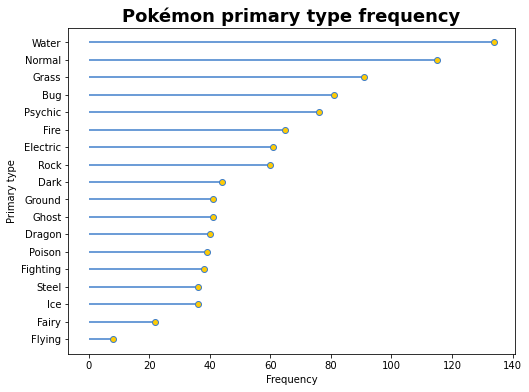

In [41]:
lolly_ax = lollypop(pokemon.type_1,
                    figsize=(8, 6),
                    hlines_kwargs={"color": blue},
                    plot_kwargs={"mec": blue,
                                 "mfc": yellow})

lolly_ax.set(ylabel="Primary type", xlabel="Frequency")
lolly_ax.set_title("Pokémon primary type frequency", title_default)

Here's an example of how to use `lollypop()`. Rolling your own function for different plot types is always useful. I'd have to write all of the code above multiple times if I didn't encapsulate a lollypop plot into a function.

# Histograms and density plots

Histograms and density plots show the distribution of a continuous variable. Histograms are essentially bar plots for continuous data. A bar plot (or a lollypop plot) graphs the counts of a categorical variable. For example, a bar plot is useful to graph the counts of a gender or race variable. Gender and race are nominal thus they can only be counted.

Bar plots are invalid for continuous data. Each bar would be very small because data aren't likely to include many values for, say, 14.01. Histograms bin values. Let's say we have data ranging from 0 to 10. We can bin the values so that everything from `[0, 1]` is in one bin and then everything in `(1, 2]` is another bin et cetera. Finally we can plot those values.

In [42]:
default_rng = np.random.default_rng()
X_norm = default_rng.normal(5, 5, 200)
X_binned = np.histogram(X_norm, bins=10)
X_binned

(array([ 5, 16, 19, 29, 24, 32, 37, 18, 12,  8], dtype=int64),
 array([-6.38005992, -4.08382608, -1.78759225,  0.50864159,  2.80487543,
         5.10110926,  7.3973431 ,  9.69357694, 11.98981077, 14.28604461,
        16.58227845]))

The first array is the counts of each bin while the second array is the edges of each bin. We don't have to use `NumPy` to calculate these each time of course. `matplotlib` and `seaborn` bin the values for us.

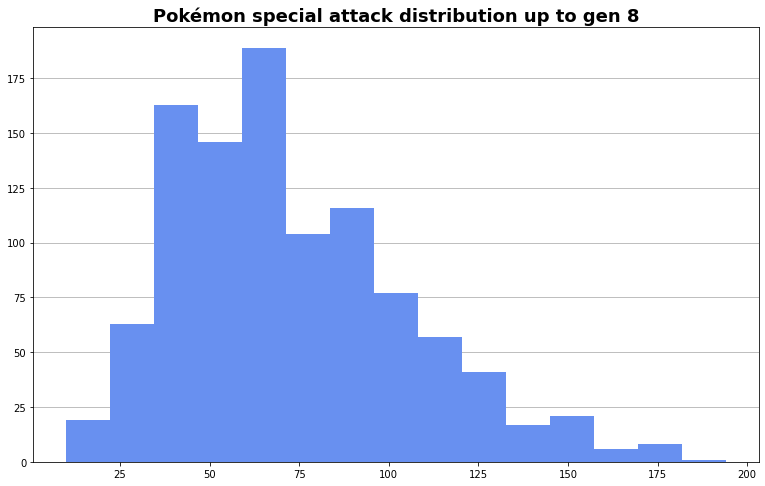

In [43]:
hist_fig, hist_ax = plt.subplots(figsize=(13, 8))

hist_ax.hist(pokemon.sp_attack,
             bins="doane",
             color=stat_colors["Sp. Atk."])

# Labels and aesthetics
hist_ax.set_xlabel=("Special attack stat", lab_default)
hist_ax.set_title(f"Pokémon special attack distribution up to gen {pokemon.generation.max()}",
                  title_default)
hist_ax.grid(axis='y')
hist_ax.set_axisbelow(True)